# <center>Model building

In [1]:
import os
workdir = ".."
os.chdir(workdir)

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')

In [3]:
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy as sc
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from numpy.linalg import LinAlgError

from itertools import product

import warnings

In [4]:
from datetime import datetime, timedelta

In [5]:
import json

In [6]:
import tqdm

In [8]:
path_to_model = "model_settings"
path_to_modelarchive = "models_store"

In [9]:
data_path = "data"

train_file = "train.csv"
test_file = "test.csv"

In [10]:
def read_data(store_id, file_name=train_file, path=data_path):
    data = pd.read_csv(os.path.join(path, file_name), index_col=1, parse_dates=True)
    data = data[data.id == store_id].drop("id", axis=1)
    return data

## <center>Построение модели

Для оценки качества построенной модели ее нужно будет **валидировать**.

### О валидации
Валидация во временных рядах имеет особенности:    
- временные ряды нельзя перемешивать
- валидировать корректно только на более поздних данных чем те, на которых модель обучалась

В связи с этим будем разбивать данные по каждому магазину на две части - тренировочные данные (обозначение **data**), и данные для валидации (обозначение **valid**)

Итак,    
**valid** - последние 31 значений   
**data** - все остальные

## Готовим данные   

In [11]:
store_id = 0

In [12]:
train = read_data(store_id)

In [13]:
train.head()

,target
dt,
2016-01-02,747.8
2016-01-03,681.2
2016-01-04,505.8
2016-01-06,1078.3
2016-01-07,961.9


In [14]:
train.shape

(453, 1)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 453 entries, 2016-01-02 to 2017-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  453 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


### Gaps in data
Как выяснили в предварительном исследовании, в данных есть пропуски.     
Согласно исследованию пропусков (см. ноутбук data_research.ipynb) заполним пропуски соседними значениями

In [16]:
def fill_vacation(data):
    ind = data.index
    full_ind = pd.date_range(ind[0], ind[-1], freq='D')
    data = pd.DataFrame(data, index=full_ind)
    ind_with_nan = data.index[data.target.isnull()]
    data = data.fillna(method="ffill")
    return data, ind_with_nan

In [18]:
train_filled, ind_with_nan = fill_vacation(train)

In [21]:
# ind_with_nan

In [19]:
train_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 546 entries, 2016-01-02 to 2017-06-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  546 non-null    float64
dtypes: float64(1)
memory usage: 8.5 KB


#### Разделим данные на тренировочные (**data**) и валидационные (**valid**) в соответствие с выбранной ранее стратегией

In [20]:
prediction_horizon = 31

data, valid = train_filled[:-prediction_horizon].copy(), train_filled[-prediction_horizon:].copy()

## Посмотрим на данные, изучим визуально сезонность

In [21]:
target_col = "target"

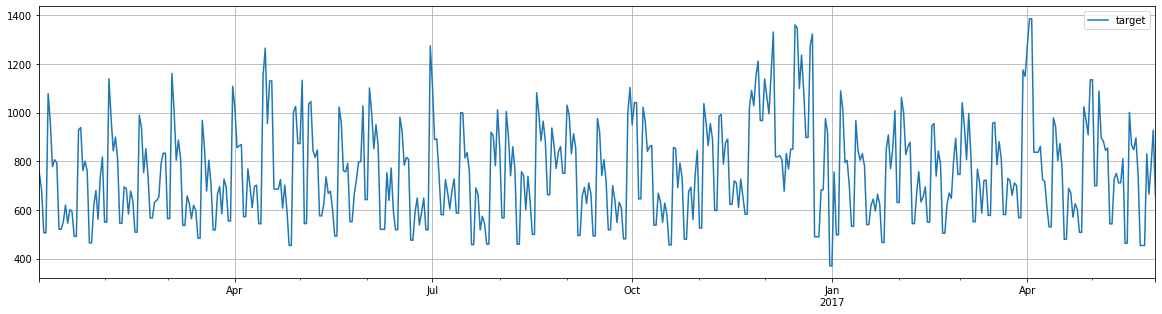

In [22]:
plt.figure(figsize=(20, 5))
data[target_col].plot()
plt.legend()
plt.grid()

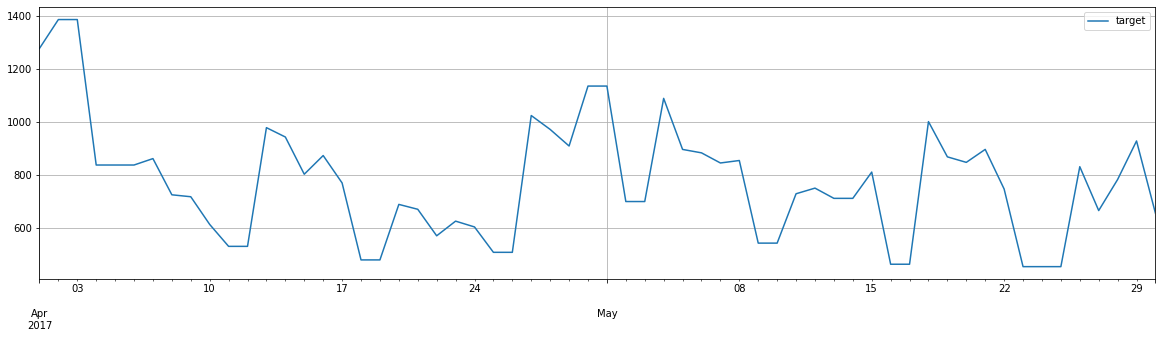

In [23]:
plt.figure(figsize=(20, 5))
data[target_col].iloc[-60:].plot()
plt.legend()
plt.grid()

Видим некоторую осциляцию, похожую на сезонность, с периодом около 2 недель

## Создадим регрессионные признаки для учёта сезонностей и трендов.

In [24]:
# для недельной сезонности
k_season_series = [1, 2, 3, 4, 5, 6]
hours_in_week = 168 # число часов в 2 неделях
for i in k_season_series:
    data[f'weekly_SIN_{i}'.replace(".", "_")] = np.sin((np.arange(len(data)) + 1) * 2*np.pi * i / hours_in_week)
    data[f'weekly_COS_{i}'.replace(".", "_")] = np.cos((np.arange(len(data)) + 1) * 2*np.pi * i / hours_in_week)

In [25]:
# конец и начало месяца
data['month_end'] = data.index.is_month_end.astype(int)
data['month_start'] = data.index.is_month_start.astype(int)

Добавим в датафрейм день недели и выходной в качестве категориальных переменных

In [26]:
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6]).astype(int)
data.head()

,target,weekly_SIN_1,weekly_COS_1,weekly_SIN_2,weekly_COS_2,weekly_SIN_3,weekly_COS_3,weekly_SIN_4,weekly_COS_4,weekly_SIN_5,weekly_COS_5,weekly_SIN_6,weekly_COS_6,month_end,month_start,weekday,is_weekend
2016-01-02,747.8,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,0.974928,0,0,5,1
2016-01-03,681.2,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,0.900969,0,0,6,1
2016-01-04,505.8,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,0.781831,0,0,0,0
2016-01-05,505.8,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,0.781831,0.623490,0,0,1,0
2016-01-06,1078.3,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,0.900969,0.433884,0,0,2,0


Добавим признак четной и нечетной недели

In [27]:
data['is_even_week'] = ((data.index.isocalendar().week % 2).astype(int) == 0).astype(int)

In [28]:
data.head(10)

,target,weekly_SIN_1,weekly_COS_1,weekly_SIN_2,weekly_COS_2,weekly_SIN_3,weekly_COS_3,weekly_SIN_4,weekly_COS_4,weekly_SIN_5,weekly_COS_5,weekly_SIN_6,weekly_COS_6,month_end,month_start,weekday,is_weekend,is_even_week
2016-01-02,747.8,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,9.749279e-01,0,0,5,1,0
2016-01-03,681.2,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,9.009689e-01,0,0,6,1,0
2016-01-04,505.8,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,7.818315e-01,0,0,0,0,0
2016-01-05,505.8,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,0.781831,6.234898e-01,0,0,1,0,0
2016-01-06,1078.3,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,0.900969,4.338837e-01,0,0,2,0,0
2016-01-07,961.9,0.222521,0.974928,0.433884,0.900969,0.623490,0.781831,0.781831,0.623490,0.900969,0.433884,0.974928,2.225209e-01,0,0,3,0,0
2016-01-08,778.5,0.258819,0.965926,0.500000,0.866025,0.707107,0.707107,0.866025,0.500000,0.965926,0.258819,1.000000,6.123234e-17,0,0,4,0,0
2016-01-09,805.9,0.294755,0.955573,0.563320,0.826239,0.781831,0.623490,0.930874,0.365341,0.997204,0.074730,0.974928,-2.225209e-01,0,0,5,1,0
2016-01-10,793.4,0.330279,0.943883,0.623490,0.781831,0.846724,0.532032,0.974928,0.222521,0.993712,-0.111964,0.900969,-4.338837e-01,0,0,6,1,0
2016-01-11,520.7,0.365341,0.930874,0.680173,0.733052,0.900969,0.433884,0.997204,0.074730,0.955573,-0.294755,0.781831,-6.234898e-01,0,0,0,0,1


## Регрессия целевого признака

In [29]:
# Список призднаков для регрессии
feature_list = []
feature_list = data.drop(target_col, axis=1).columns
feature_list

Index(['weekly_SIN_1', 'weekly_COS_1', 'weekly_SIN_2', 'weekly_COS_2',
       'weekly_SIN_3', 'weekly_COS_3', 'weekly_SIN_4', 'weekly_COS_4',
       'weekly_SIN_5', 'weekly_COS_5', 'weekly_SIN_6', 'weekly_COS_6',
       'month_end', 'month_start', 'weekday', 'is_weekend', 'is_even_week'],
      dtype='object')

### use smf.ols

In [30]:
m1 = smf.ols('target ~ ' + ' + '.join(feature_list), data=data)
# fitted = m1.fit()
fitted = m1.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     5.770
Date:                Sat, 11 Sep 2021   Prob (F-statistic):           4.28e-12
Time:                        15:40:17   Log-Likelihood:                -3416.5
No. Observations:                 515   AIC:                             6869.
Df Residuals:                     497   BIC:                             6945.
Df Model:                          17                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      640.6877     20.194     31.726   

Посмотрим на остатки

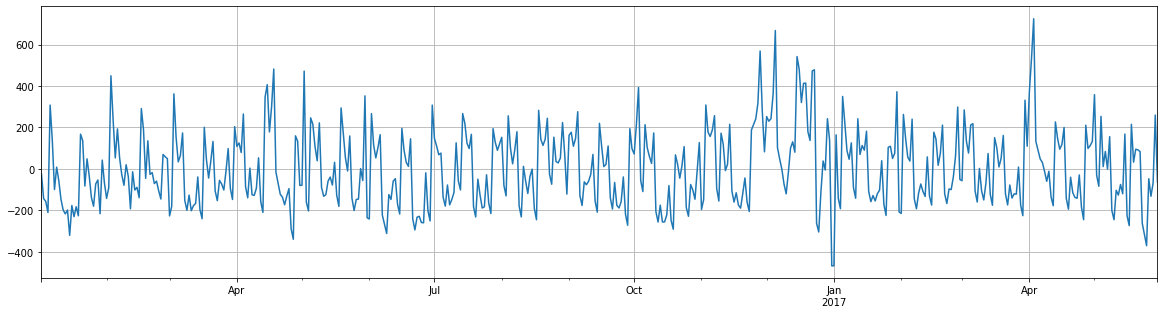

In [31]:
plt.figure(figsize=(20, 5))
fitted.resid.plot();
plt.grid()

В остатках много структуры.

Посмотрим на распределение остатков

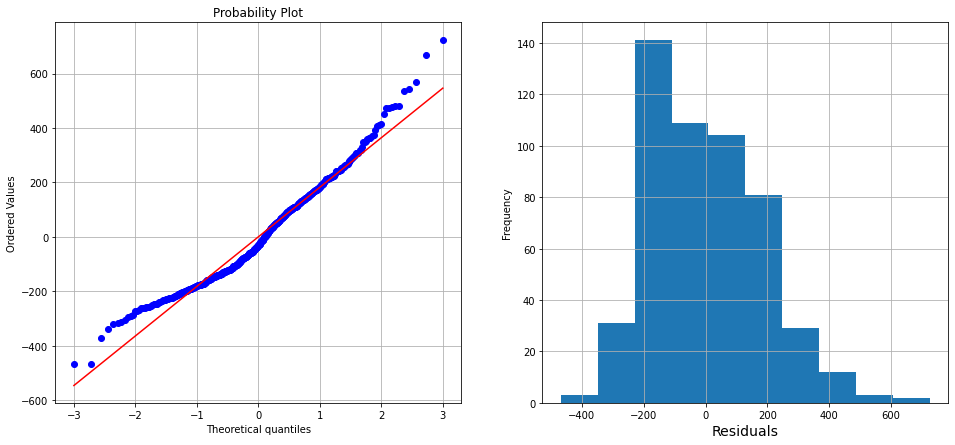

In [32]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=plt)
plt.grid()
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.grid()

Распределение близко к гауссову, сделаем некоторые преобразования, чтобы еще более приблизить его к гауссову и к стационарному

## Подбор значения гиперпараметров ARIMA

Посмотрим на **STL-декомпозицию**

Критерий Дики-Фуллера: p=1.950360e-05


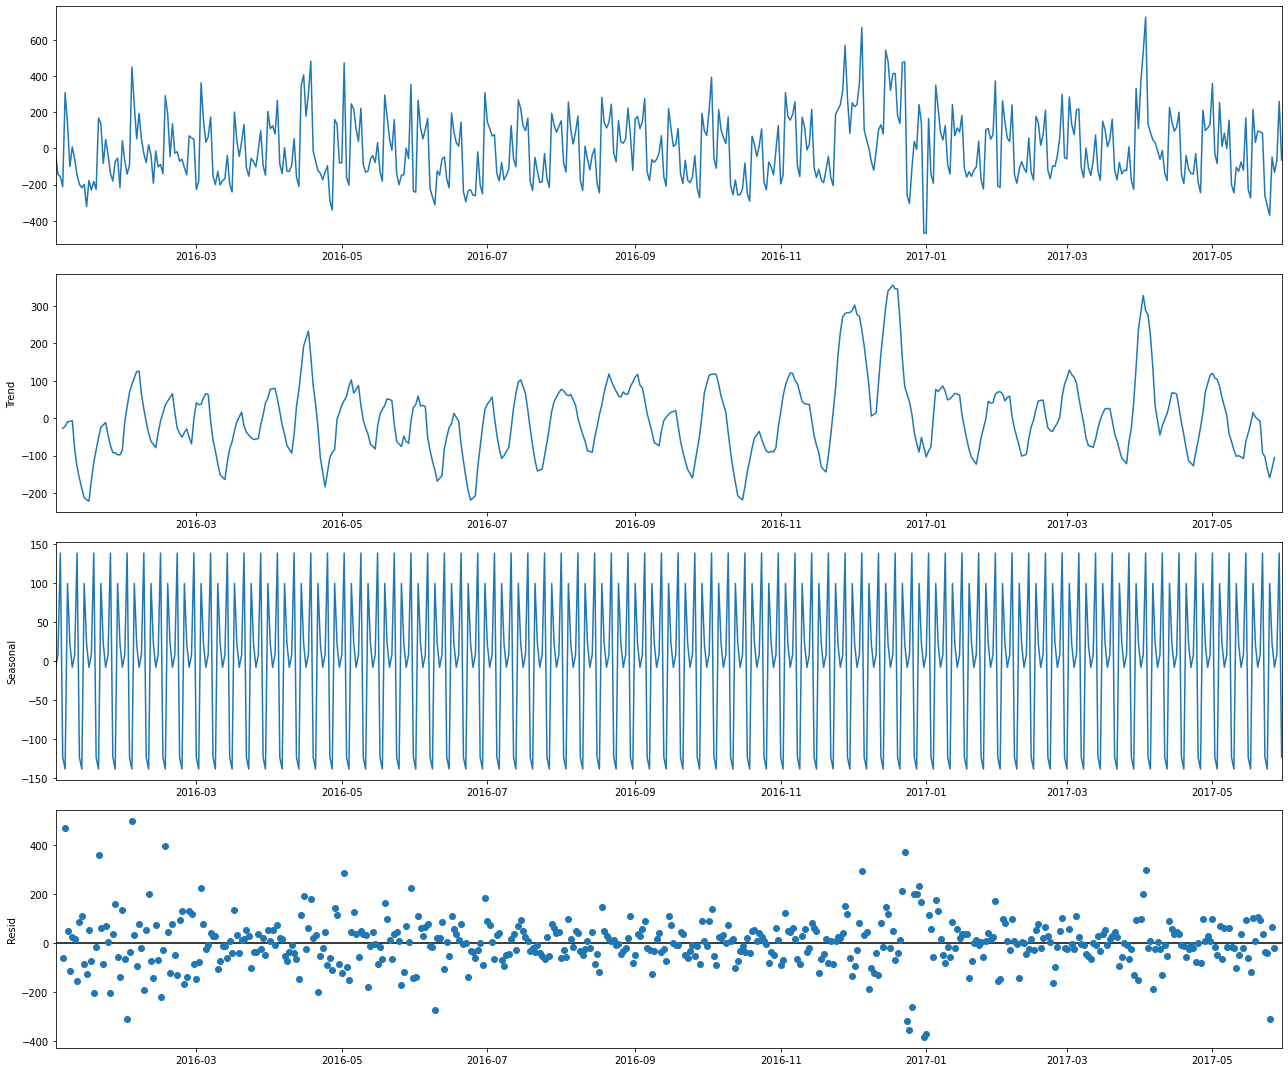

In [33]:
plt.rcParams["figure.figsize"] = (18,15)
sm.tsa.seasonal_decompose(fitted.resid).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(fitted.resid)[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, НО, на мой взгляд, не очень уверенно.    
Напрашивается дифференцирование.   

In [34]:
col = {}
lag = 1

Критерий Дики-Фуллера: p=8.477079e-10


<Figure size 1080x720 with 0 Axes>

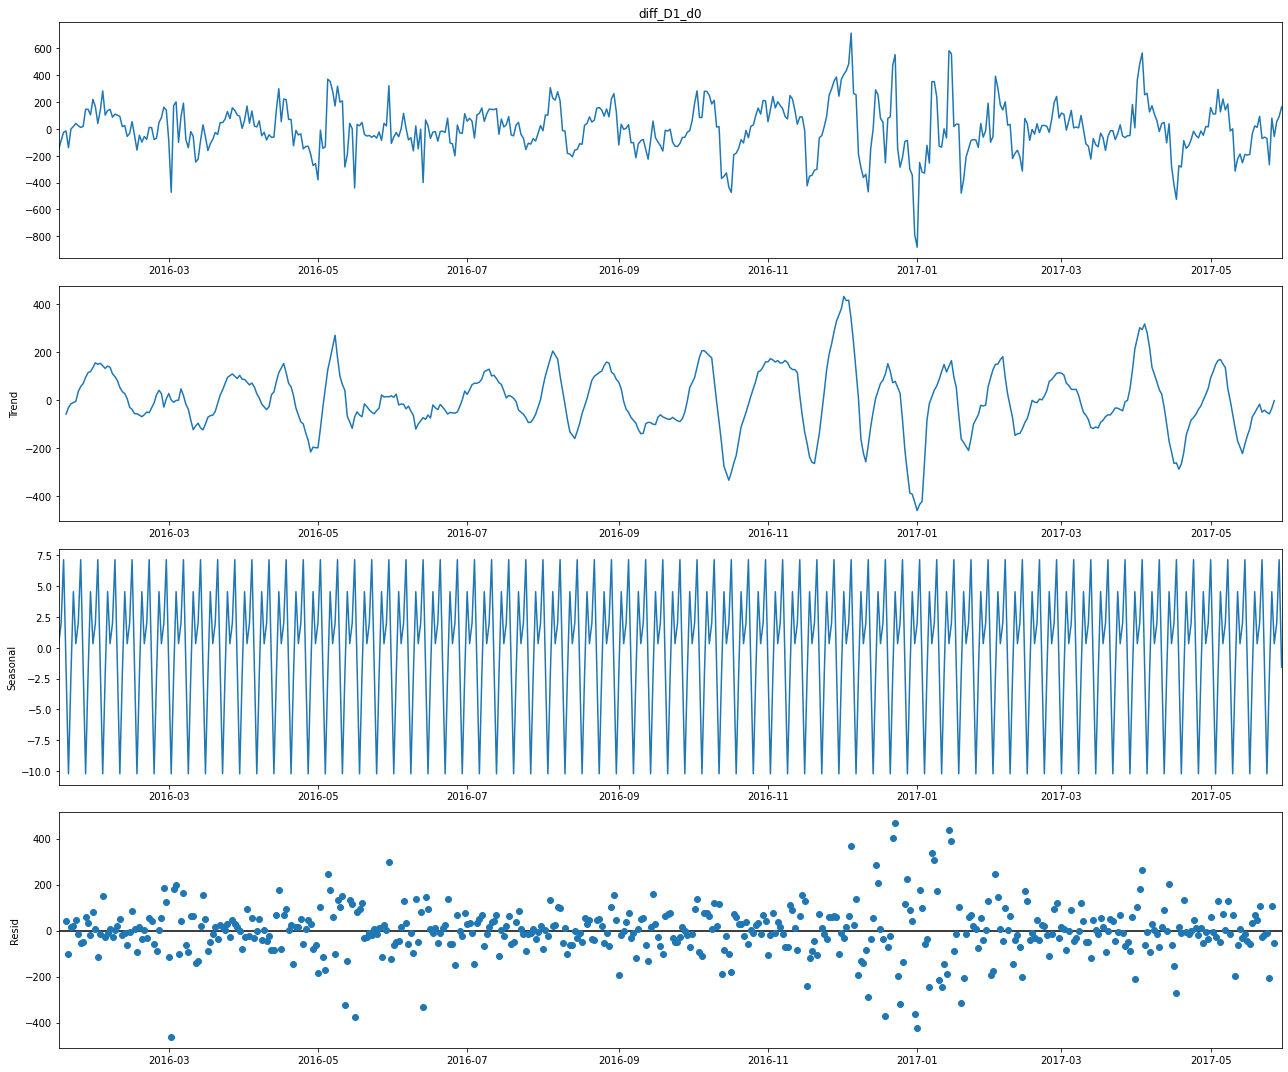

In [35]:
D = 1
S = 14
d = 0
col[(D, d)] = f"diff_D{D}_d{d}"

plt.rcParams["figure.figsize"] = (18,15)
data[col[(D, d)]] = fitted.resid - fitted.resid.shift(S)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data[col[(D, d)]][(D*S+d*lag):]).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(data[col[(D, d)]][(D*S+d*lag):])[1])

Критерий Дики-Фуллера: p=5.219290e-17


<Figure size 1080x720 with 0 Axes>

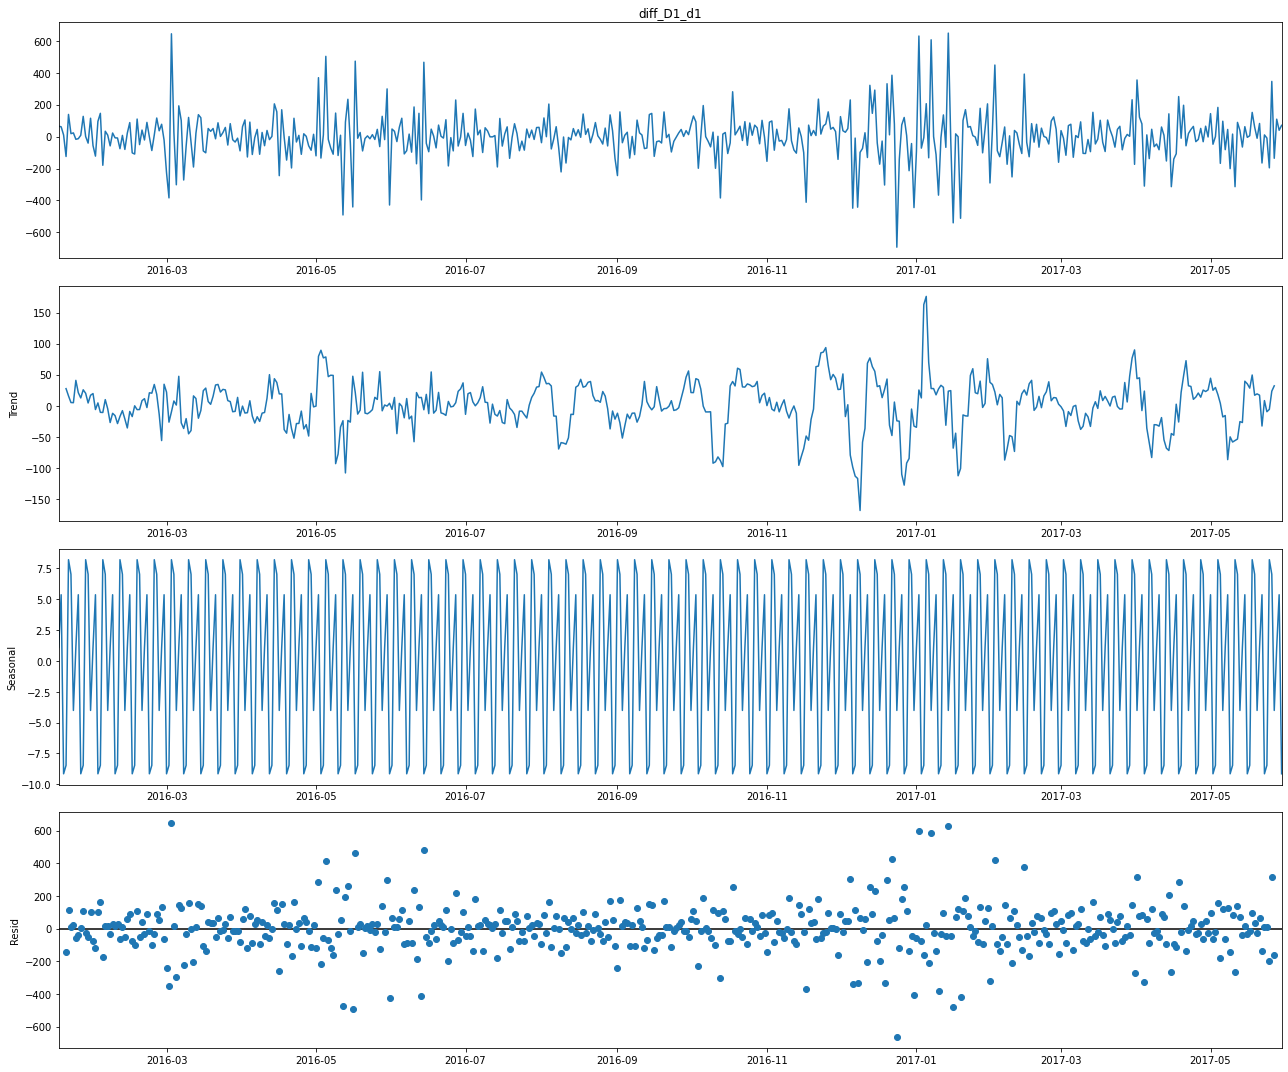

In [36]:
D = 1
S = S
d = 1
col[(D, d)] = f"diff_D{D}_d{d}"

plt.rcParams["figure.figsize"] = (18,15)
data[col[(D, d)]] = data[col[(D, d-1)]] - data[col[(D, d-1)]].shift(lag)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data[col[(D, d)]][(D*S+d*lag):]).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(data[col[(D, d)]][(D*S+d*lag):])[1])

Критерий Дики-Фуллера позволяет считать ряд стационарным.   
Мы провели два дифференцирования - сезонное (сезон = 14 дней) и соседних значений.   

### подбираем p,q,P,Q

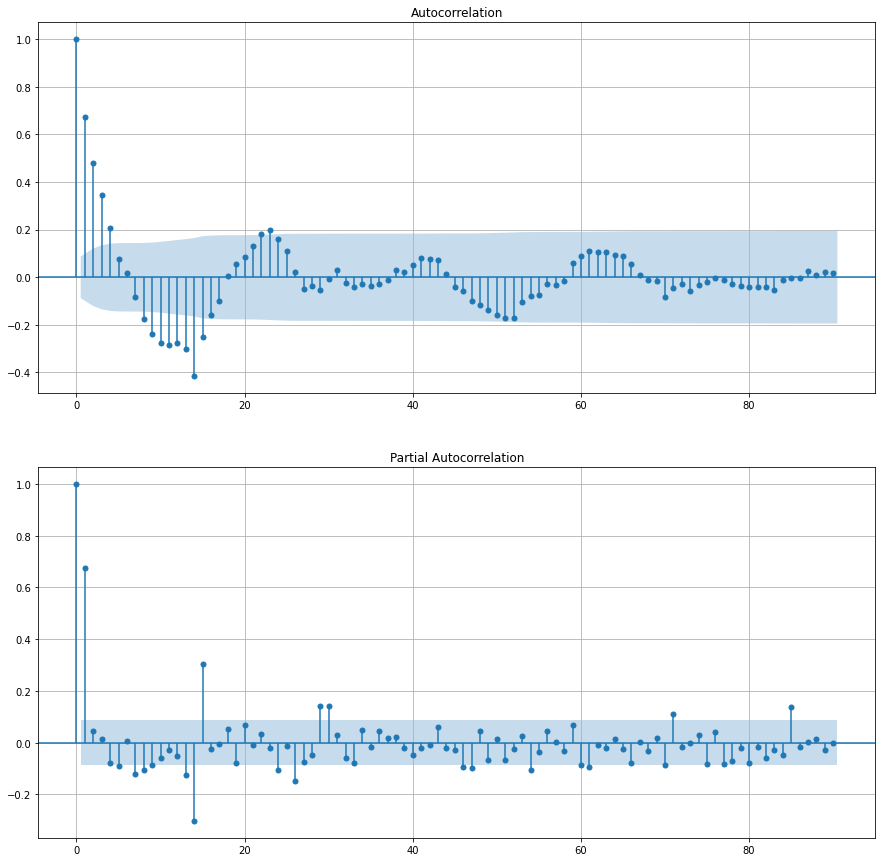

In [37]:
D = 1
d = 0

plt.figure(figsize=(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
plt.show()

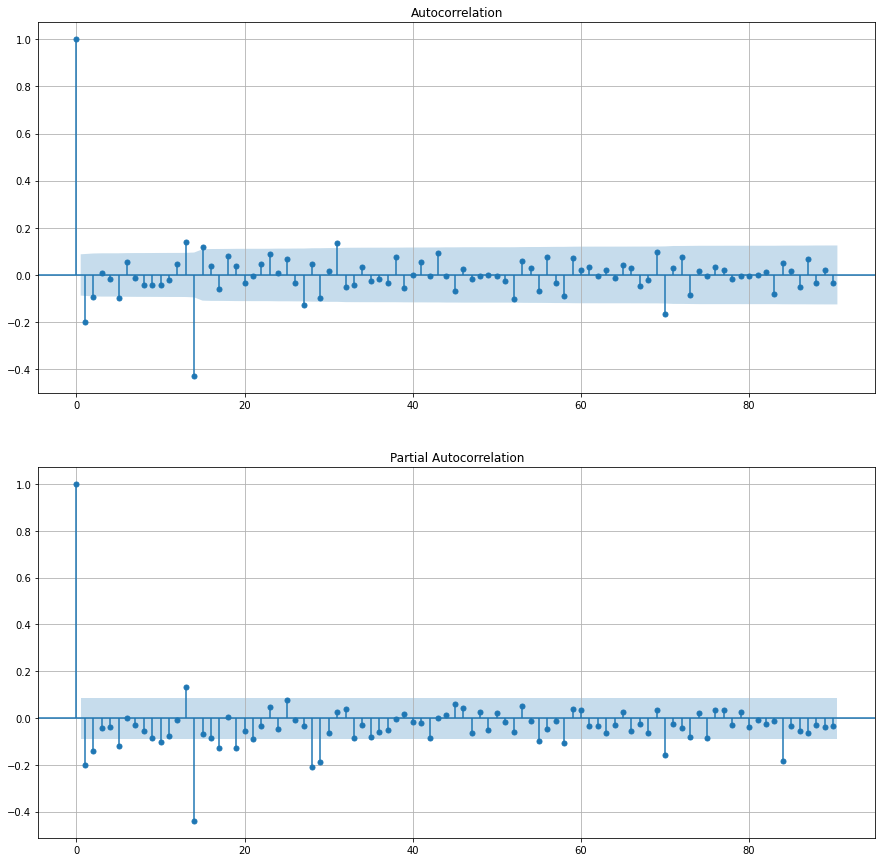

In [39]:
D = 1
d = 1

plt.figure(figsize=(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
plt.show()

Выводы: хотя критерий Дики-Фуллера позволяет считать ряд стационарным уже после первого сезонного дифференцирования, сезон = 14 дней, но в данных еще видно много структуры. Второе дифференцирование с лагом = 1 день этот вопрос снимает.

$SARIMA(p,d,q)(P,D,Q)_S$

### Подбор AIC модели
- Выберем оптимальную по AIC модель; 
- построим график исходного ряда и нарисуем поверх предсказания выбранной модели. 

Если модель плохо описывает данные, попробуем увеличить количество синусов и косинусов K или поменять порядки дифференцирования.

In [40]:
D = 1
d = 1
S = S  # 14
lag = lag  # 1

q = 2
p = 2

Q = 1
P = 2

In [41]:
ps = range(p + 1)
qs = range(q + 1)
Ps = range(P + 1)
Qs = range(Q + 1)

In [42]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

#### Функции для сохранения промежуточных результатов
Во время расчетов по подбору оптимальных параметров иногда происходит срубание процесса из-за нехватки ресурсов. При этом все рассчитанные до этого параметры частенько не сохраняются. Чтобы избежать этого, сделаем сохранение результата в каждом цикле. Для этого напишем соответствующую функцию и вставим ее в цикл.

In [43]:
def get_save_params(store_id):
    model_id = f"{store_id}"
    
    # the file names
    model_file_name = f"model_{model_id}.arima"
    hyperparams_file_name = f"hyperparams_{model_id}.json"
    params_df_file_name = f"params_{model_id}.csv"
    
    return model_id, hyperparams_file_name, params_df_file_name, model_file_name

In [44]:
def save_results(results, best_params, store_id, path_to_model, comment,  k_season_series, model_save=False):
    """
    The save of the current results and best params of the model calculation
    """
    # params for saving
    model_id, hyperparams_file_name, params_df_file_name, model_file_name = get_save_params(store_id)
    
    # model
    if model_save:
        best_model.save(os.path.join(path_to_model, model_file_name))
    
    # best params
    best_params_dict = dict()
    best_params_dict['p'] = best_params[0]
    best_params_dict['q'] = best_params[1]
    best_params_dict['d'] = d
    best_params_dict['P'] = best_params[2]
    best_params_dict['Q'] = best_params[3]
    best_params_dict['D'] = D
    best_params_dict['S'] = S
    best_params_dict["k_season_series"] = k_season_series
    best_params_dict['Comment'] = comment

    with open(os.path.join(path_to_model, hyperparams_file_name), "w") as file:
        json.dump(best_params_dict, file)
        
    # common results (all params)
    params_df = pd.DataFrame(list(map(lambda x: x[0], results)), columns=['p', 'q', 'P', 'Q'])
    params_df['aic'] = list(map(lambda x: x[1], results))
    params_df['culc_time_in_minutes'] = list(map(lambda x: x[2], results))
    params_df_sorted = params_df.sort_values(by = 'aic', ascending=True)
    params_df_sorted.to_csv(os.path.join(path_to_model, params_df_file_name))
    
    return model_id, hyperparams_file_name, params_df_file_name, model_file_name

In [45]:
comment = f"store_id = {store_id}"

### Подбор гиперпараметров модели SARIMA

In [46]:
%%time
results = []
best_aic = float("inf")
best_params = None
warnings.filterwarnings('ignore')

for params in tqdm.tqdm(parameters_list, total=len(parameters_list)):
    start_time = datetime.now()
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog=data[target_col], 
                                        exog=data[feature_list], 
                                        order=(params[0], d, params[1]), 
                                        seasonal_order=(params[2], D, params[3], S)).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters (ValueError):', params)
        continue
    except LinAlgError:
        print('wrong parameters (LinAlgError):', params)
        continue
    except MemoryError as error:
        print(f"MemoryError message: {error}")
        print('wrong parameters (MemoryError):', params)
        continue
    except Exception as exception:
        print(f"Exception message: {exception}")
        print('wrong parameters (Exception):', params)
        continue
        
    end_time = datetime.now()
    model_culc_time_minutes = round((end_time - start_time).seconds / 60, 2)
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_params = params
    results.append([params, model.aic, model_culc_time_minutes])
    
    # save the current results
    model_id, hyperparams_file_name, params_df_file_name, model_file_name = \
        save_results(results, best_params, store_id, path_to_model, comment,  k_season_series)
    
warnings.filterwarnings('default')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [13:29<00:00, 14.99s/it]

Wall time: 13min 29s


## Посмотрим на результат

In [49]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             target   No. Observations:                  515
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 14)   Log Likelihood               -3087.967
Date:                            Sat, 11 Sep 2021   AIC                           6221.935
Time:                                    16:04:49   BIC                           6318.871
Sample:                                01-02-2016   HQIC                          6259.973
                                     - 05-30-2017                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
weekly_SIN_1   -19.5696     45.381     -0.431      0.666    -108.516      69.376
weekly_COS_1   -10.2640     40.160     -0.256      0.798     -88.976      68.448
weekly_SIN_2     8.1307     27.088      0.300      0.764     -44.961      61.222
weekly_COS_2    16.4912     23.699      0.696      0.487     -29.959      62.941
weekly_SIN_3    13.9836     20.369      0.687      0.492     -25.938      53.906
weekly_COS_3    31.0897     21.581      1.441      0.150     -11.208      73.387
weekly_SIN_4    -7.1397     18.962     -0.377      0.707     -44.304      30.025
weekly_COS_4   -14.6606     19.142     -0.766      0.444     -52.179      22.858
weekly_SIN_5     3.4603     18.698      0.185      0.853     -33.187      40.107
weekly_COS_5   -12.4648     19.783     -0.630      0.529     -51.240      26.310
weekly_SIN_6    17.4484     17.718      0.985      0.325     -17.278      52.175
weekly_COS_6   -13.2301     20.429     -0.648      0.517     -53.271      26.810
month_end       34.9446     18.477      1.891      0.059      -1.269      71.159
month_start    -16.3881     20.192     -0.812      0.417     -55.964      23.188
weekday         -0.3799   2609.505     -0.000      1.000   -5114.915    5114.155
is_weekend      -0.1504   2507.185     -6e-05      1.000   -4914.143    4913.842
is_even_week   -80.7581    290.061     -0.278      0.781    -649.266     487.750
ar.L1            0.6962      0.032     22.095      0.000       0.634       0.758
ma.L1           -0.9999      1.311     -0.763      0.446      -3.569       1.569
ar.S.L14         0.3878      0.045      8.648      0.000       0.300       0.476
ar.S.L28         0.1926      0.046      4.177      0.000       0.102       0.283
ma.S.L14        -0.9997      5.195     -0.192      0.847     -11.182       9.183
sigma2        1.245e+04   6.96e+04      0.179      0.858   -1.24e+05    1.49e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               311.70
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.23
Prob(H) (two-sided):                  0.52   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## <center>Save the best model

In [50]:
model_id, hyperparams_file_name, params_df_file_name, model_file_name = get_save_params(store_id)

In [51]:
print("model_id:", model_id)
print("hyperparams_file_name:", hyperparams_file_name)
print("params_df_file_name:", params_df_file_name)
print("model_file_name:", model_file_name)

model_id: 0
hyperparams_file_name: hyperparams_0.json
params_df_file_name: params_0.csv
model_file_name: model_0.arima


#### model

In [52]:
best_model.save(os.path.join(path_to_modelarchive, model_file_name))

## <center>Load the best model and saved params

In [113]:
# loaded_model = sm.load(os.path.join(path_to_modelarchive, model_file_name))
# loaded_model.summary()

In [55]:
# load test
with open(os.path.join(path_to_model, hyperparams_file_name)) as file:
    best_params_dict = json.load(file)
best_params_dict

{'p': 1,
 'q': 1,
 'd': 1,
 'P': 2,
 'Q': 1,
 'D': 1,
 'S': 14,
 'k_season_series': [1, 2, 3, 4, 5, 6],
 'Comment': 'store_id = 0'}

In [56]:
params = pd.read_csv(os.path.join(path_to_model, params_df_file_name), index_col=0)
params.head()

,p,q,P,Q,aic,culc_time_in_minutes
29,1,1,2,1,6221.934987,0.48
47,2,1,2,1,6223.412374,0.55
35,1,2,2,1,6223.446212,0.52
53,2,2,2,1,6225.484550,0.70
27,1,1,1,1,6235.128040,0.22


### Посмотрим, как модель описывает данные

In [87]:
model = best_model
# model = loaded_model

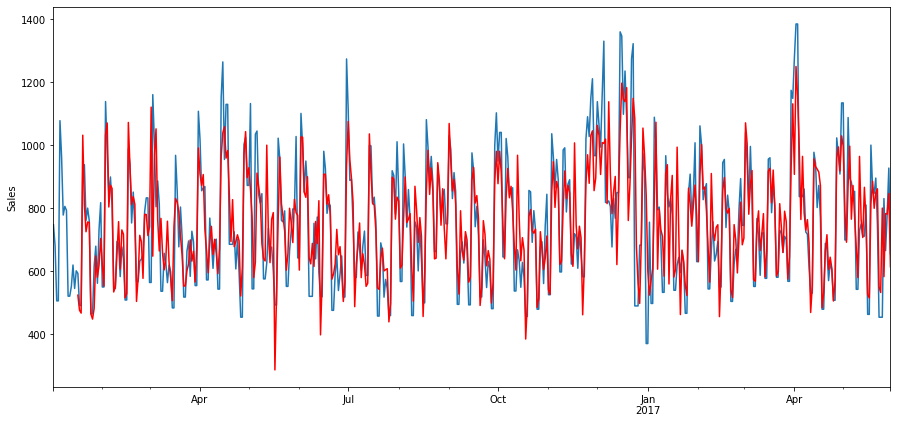

In [88]:
data['model'] = model.fittedvalues
plt.figure(figsize=(15,7))
data[target_col].plot()
data['model'][(D*S + d*lag):].plot(color='r')
plt.ylabel('Sales')
plt.show()

Посмотрим на то же, но на **last_samples** последних отсчетах (для наглядности):

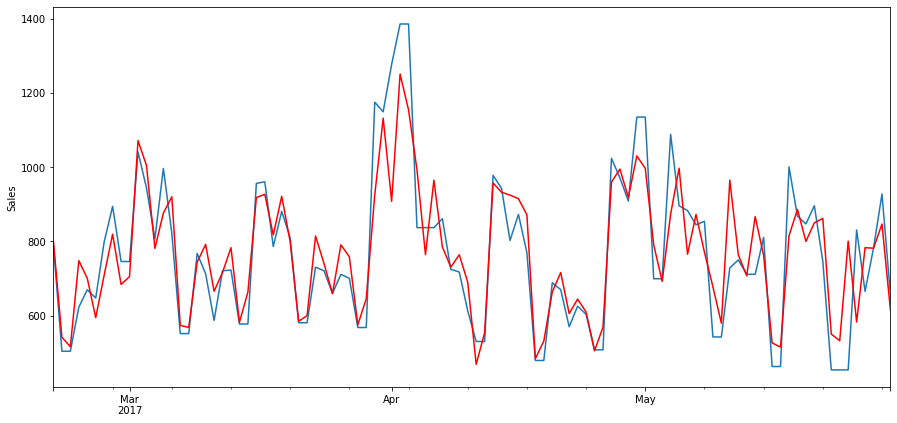

In [89]:
last_samples = 100

plt.figure(figsize=(15,7))
data[target_col][-last_samples:].plot()
data['model'][(D*S + lag):][-last_samples:].plot(color='r')
plt.ylabel('Sales')
plt.show()

## <center>Прогноз

In [90]:
data.index[-1]

Timestamp('2017-05-30 00:00:00', freq='D')

In [91]:
start_future = (data.index[-1] + timedelta(days=1)).strftime('%Y-%m-%d %H:%M:%S') # начальная дата прогноза
start_future

'2017-05-31 00:00:00'

In [92]:
# формируем временной ряд для прогноза 
end_future = (datetime.strptime(start_future, '%Y-%m-%d %H:%M:%S') + 
              (prediction_horizon - 1) * timedelta(days=1)).strftime('%Y-%m-%d %H:%M:%S') # конечная дата
end_future

'2017-06-30 00:00:00'

In [93]:
date_list = pd.date_range(start_future, end_future, freq="D") # временной ряд для прогноза 

In [94]:
date_list

DatetimeIndex(['2017-05-31', '2017-06-01', '2017-06-02', '2017-06-03',
               '2017-06-04', '2017-06-05', '2017-06-06', '2017-06-07',
               '2017-06-08', '2017-06-09', '2017-06-10', '2017-06-11',
               '2017-06-12', '2017-06-13', '2017-06-14', '2017-06-15',
               '2017-06-16', '2017-06-17', '2017-06-18', '2017-06-19',
               '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',
               '2017-06-24', '2017-06-25', '2017-06-26', '2017-06-27',
               '2017-06-28', '2017-06-29', '2017-06-30'],
              dtype='datetime64[ns]', freq='D')

### создаем признаки для прогноза

#### заготовка для прогноза

In [95]:
data_draft = data[[target_col]].copy()
future = pd.DataFrame(index=date_list, columns= data_draft.columns) # заготовка для прогноза

#### exog

In [96]:
# для недельной сезонности
for i in k_season_series:
    future[f'weekly_SIN_{i}'.replace(".", "_")] = np.sin((np.arange(len(data) + 1, len(data) + len(date_list) + 1)) * 
                                     2*np.pi * i / hours_in_week)
    future[f'weekly_COS_{i}'.replace(".", "_")] = np.cos((np.arange(len(data) + 1, len(data) + len(date_list) + 1)) * 
                                     2*np.pi * i / hours_in_week)

In [97]:
future["weekday"] = future.index.weekday
future['is_weekend'] = future.index.weekday.isin([5, 6]).astype(int)

In [98]:
future['is_even_week'] = ((future.index.isocalendar().week % 2).astype(int) == 0).astype(int)

In [99]:
# конец и начало месяца
future['month_end'] = future.index.is_month_end.astype(int)

In [100]:
future['month_start'] = future.index.is_month_start.astype(int)

In [101]:
feature_list

Index(['weekly_SIN_1', 'weekly_COS_1', 'weekly_SIN_2', 'weekly_COS_2',
       'weekly_SIN_3', 'weekly_COS_3', 'weekly_SIN_4', 'weekly_COS_4',
       'weekly_SIN_5', 'weekly_COS_5', 'weekly_SIN_6', 'weekly_COS_6',
       'month_end', 'month_start', 'weekday', 'is_weekend', 'is_even_week'],
      dtype='object')

### заготовка для прогноза со сгенерированными дополнительными признаками

In [102]:
future.head()

,target,weekly_SIN_1,weekly_COS_1,weekly_SIN_2,weekly_COS_2,weekly_SIN_3,weekly_COS_3,weekly_SIN_4,weekly_COS_4,weekly_SIN_5,weekly_COS_5,weekly_SIN_6,weekly_COS_6,weekday,is_weekend,is_even_week,month_end,month_start
2017-05-31,NaN,0.433884,0.900969,0.781831,0.623490,0.974928,2.225209e-01,0.974928,-0.222521,0.781831,-0.623490,4.338837e-01,-0.900969,2,0,1,1,0
2017-06-01,NaN,0.467269,0.884115,0.826239,0.563320,0.993712,1.119645e-01,0.930874,-0.365341,0.652287,-0.757972,2.225209e-01,-0.974928,3,0,1,0,1
2017-06-02,NaN,0.500000,0.866025,0.866025,0.500000,1.000000,7.594667e-15,0.866025,-0.500000,0.500000,-0.866025,1.518933e-14,-1.000000,4,0,1,0,0
2017-06-03,NaN,0.532032,0.846724,0.900969,0.433884,0.993712,-1.119645e-01,0.781831,-0.623490,0.330279,-0.943883,-2.225209e-01,-0.974928,5,1,1,0,0
2017-06-04,NaN,0.563320,0.826239,0.930874,0.365341,0.974928,-2.225209e-01,0.680173,-0.733052,0.149042,-0.988831,-4.338837e-01,-0.900969,6,1,1,0,0


Wall time: 9 ms


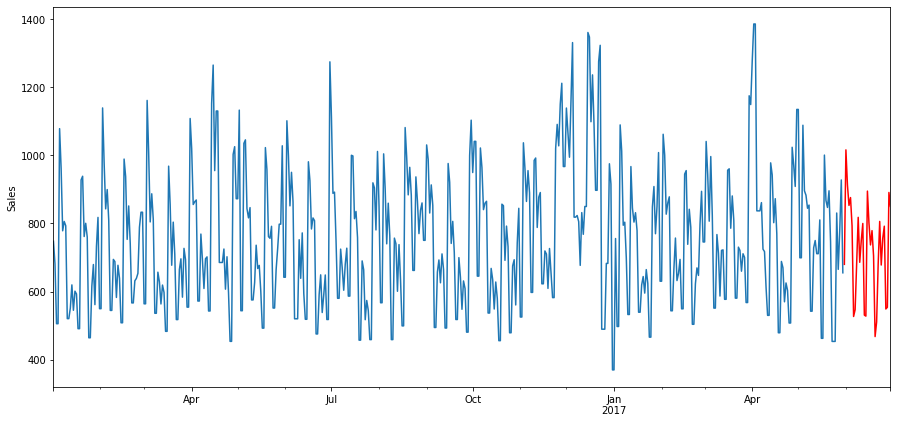

In [103]:
data_with_forecast = pd.concat([data_draft, future], sort=True)

start = len(data)
end = len(data) + len(date_list) - 1

exog_future = future.loc[date_list, feature_list]

%time data_with_forecast['forecast'] = model.predict(start=start, end=end, exog=exog_future).astype(int).clip(0)

plt.figure(figsize=(15,7))
data_with_forecast[target_col].plot()
data_with_forecast['forecast'].plot(color='r')
plt.ylabel('Sales')
plt.show()

### Комментарий
Прогноз сформирован и визуализирован, выглядит вполне адекватно

### Визуализация прогнозаа (красным) более укрупненно

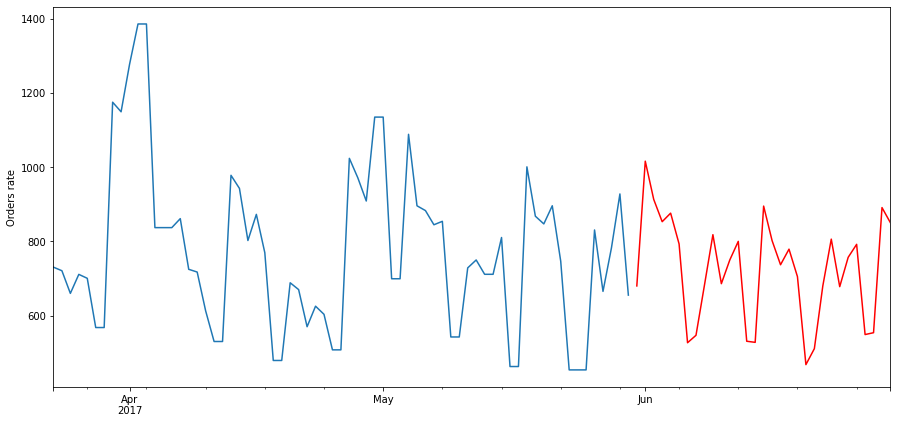

In [104]:
last_samples = 100

plt.figure(figsize=(15,7))
data_with_forecast[target_col][-last_samples:].plot()
data_with_forecast['forecast'][-last_samples:].plot(color='r')
plt.ylabel('Orders rate')
plt.show()

## <center>Model validation

Для валидации модели имеем: 
- прогноз
- отложенные заранее данные на те же даты для валидации
- метрика для валидации - sMAE

$$sMAE = \frac{E\; (\; \mid forecastError\mid\; )}{E\; (\; \mid trainTarget \mid\; )}$$

## <center>Прогноз

In [105]:
forecast = data_with_forecast[['forecast']].tail(prediction_horizon).copy()
forecast

,forecast
2017-05-31,680.0
2017-06-01,1016.0
2017-06-02,913.0
2017-06-03,853.0
2017-06-04,876.0
2017-06-05,793.0
2017-06-06,527.0
2017-06-07,547.0
2017-06-08,682.0
2017-06-09,818.0


In [106]:
valid.columns = ["val_target"]
valid

,val_target
2017-05-31,655.2
2017-06-01,1003.8
2017-06-02,834.7
2017-06-03,766.3
2017-06-04,758.1
2017-06-05,741.4
2017-06-06,482.5
2017-06-07,482.5
2017-06-08,623.6
2017-06-09,667.6


### Визуализируем

#### добавим валидацию в данные

In [109]:
data_with_forecast = pd.concat([data_with_forecast, valid], axis=1)
data_with_forecast.tail()

,is_even_week,is_weekend,month_end,month_start,target,weekday,weekly_COS_1,weekly_COS_2,weekly_COS_3,weekly_COS_4,weekly_COS_5,weekly_COS_6,weekly_SIN_1,weekly_SIN_2,weekly_SIN_3,weekly_SIN_4,weekly_SIN_5,weekly_SIN_6,forecast,val_target
2017-06-26,1.0,0.0,0.0,0.0,NaN,0.0,1.490423e-01,-0.955573,-4.338837e-01,0.826239,6.801727e-01,-0.623490,0.988831,2.947552e-01,-0.900969,-5.633201e-01,0.733052,7.818315e-01,792.0,627.8
2017-06-27,1.0,0.0,0.0,0.0,NaN,1.0,1.119645e-01,-0.974928,-3.302791e-01,0.900969,5.320321e-01,-0.781831,0.993712,2.225209e-01,-0.943883,-4.338837e-01,0.846724,6.234898e-01,549.0,464.5
2017-06-28,1.0,0.0,0.0,0.0,NaN,2.0,7.473009e-02,-0.988831,-2.225209e-01,0.955573,3.653410e-01,-0.900969,0.997204,1.490423e-01,-0.974928,-2.947552e-01,0.930874,4.338837e-01,554.0,464.5
2017-06-29,1.0,0.0,0.0,0.0,NaN,3.0,3.739119e-02,-0.997204,-1.119645e-01,0.988831,1.859116e-01,-0.974928,0.999301,7.473009e-02,-0.993712,-1.490423e-01,0.982566,2.225209e-01,891.0,1039.9
2017-06-30,1.0,0.0,1.0,0.0,NaN,4.0,-9.803364e-16,-1.000000,-4.164418e-15,1.000000,9.309173e-15,-1.000000,1.000000,-1.960673e-15,-1.000000,3.921346e-15,1.000000,8.328836e-15,850.0,1152.9


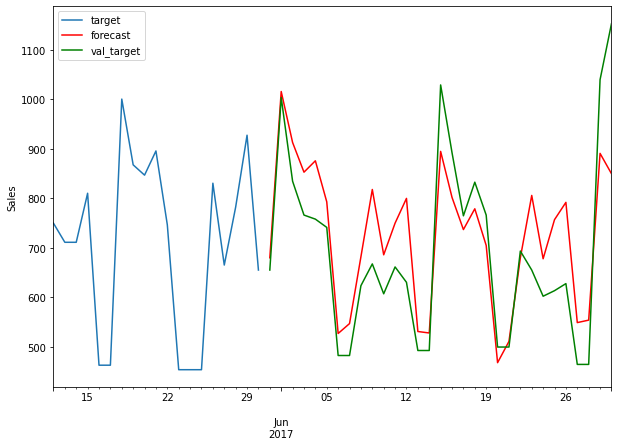

In [110]:
# plot last last_samples samples
last_samples = 50

plt.figure(figsize=(10,7))
data_with_forecast[target_col][-last_samples:].plot()
data_with_forecast['forecast'][-last_samples:].plot(color='r')
data_with_forecast['val_target'][-last_samples:].plot(color='g')
plt.ylabel('Sales')
plt.legend()
# plt.ylim(0, 700)
plt.show()

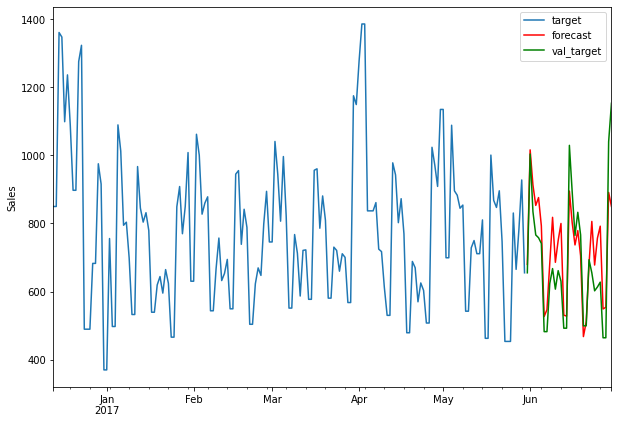

In [111]:
# plot last last_samples samples
last_samples = 200

plt.figure(figsize=(10,7))
data_with_forecast[target_col][-last_samples:].plot()
data_with_forecast['forecast'][-last_samples:].plot(color='r')
data_with_forecast['val_target'][-last_samples:].plot(color='g')
plt.ylabel('Sales')
plt.legend()
# plt.ylim(0, 700)
plt.show()

## <center>Посчитаем sMAE на предсказанных значениях

In [112]:
sMAE = (forecast["forecast"] - valid["val_target"]).abs().mean() / data["target"].abs().mean()
sMAE

0.11547995804383208

## <center>Сделаем прогноз на всех данных
Для этого завернем весь процесс в класс и обучим на всех данных

In [167]:
class SalesForecast:
    
    def __init__(self, data, params, target_col="target"):
        self.data = data.copy()
        self.params = params
        
        self.target_col = target_col
        
        self.model = None
        self.feature_list = None
        self.data_with_forecast = None
        
    def _add_features(self, data):
        # weekly seasonality
        k_season_series = self.params["k_season_series"]
        hours_in_week = 168 # number of hours of the week
        for i in k_season_series:
            data[f'weekly_SIN_{i}'.replace(".", "_")] = np.sin((np.arange(len(data)) + 1) * 2*np.pi * i / hours_in_week)
            data[f'weekly_COS_{i}'.replace(".", "_")] = np.cos((np.arange(len(data)) + 1) * 2*np.pi * i / hours_in_week)

        # конец и начало месяца
        data['month_end'] = data.index.is_month_end.astype(int)
        data['month_start'] = data.index.is_month_start.astype(int)

        data["weekday"] = data.index.weekday
        data['is_weekend'] = data.weekday.isin([5,6]).astype(int)

        data['is_even_week'] = ((data.index.isocalendar().week % 2).astype(int) == 0).astype(int)
        
        self.feature_list = data.drop(self.target_col, axis=1).columns
        
        return data
    
    def _fit(self, data):
        params = self.params
        p = params['p']
        d = params['d']
        q = params['q']
        P = params['P']
        D = params['D']
        Q = params['Q']
        S = params['S']
        
        target_col = self.target_col
        feature_list = self.feature_list
        
        model = None
        try:
            model = sm.tsa.statespace.SARIMAX(endog=data[target_col], 
                                              exog=data[feature_list], 
                                              order=(p, d, q), 
                                              seasonal_order=(P, D, Q, S)).fit()
        except ValueError:
            print('wrong parameters (ValueError):', params)
        except LinAlgError:
            print('wrong parameters (LinAlgError):', params)
        except MemoryError as error:
            print(f"MemoryError message: {error}")
            print('wrong parameters (MemoryError):', params)
        except Exception as exception:
            print(f"Exception message: {exception}")
            print('wrong parameters (Exception):', params)
            
        return model
    
    def fit(self):
        data = self._add_features(self.data)
        self.model = self._fit(data)
        
    def _get_future_template(self, prediction_horizon):
        data = self.data
        start_future = (data.index[-1] + timedelta(days=1)).strftime('%Y-%m-%d %H:%M:%S') # начальная дата прогноза
        end_future = (datetime.strptime(start_future, '%Y-%m-%d %H:%M:%S') + 
              (prediction_horizon - 1) * timedelta(days=1)).strftime('%Y-%m-%d %H:%M:%S') # конечная дата
        self.date_list = pd.date_range(start_future, end_future, freq="D") # временной ряд для прогноза 
        data_draft = data[[self.target_col]].copy()
        future = pd.DataFrame(index=self.date_list, columns=data_draft.columns) # заготовка для прогноза
        return future, data_draft
    
    def _get_data_with_forecast(self, prediction_horizon):
        data = self.data
        future_template, data_draft = self._get_future_template(prediction_horizon)
        
        future_template = self._add_features(future_template)
        data_with_forecast = pd.concat([data_draft, future_template], sort=True)

        start = len(data)
        end = len(data) + len(self.date_list) - 1

        exog_future = future_template.loc[self.date_list, self.feature_list]

        data_with_forecast['forecast'] = np.round(self.model.predict(start=start, end=end, exog=exog_future), 1).clip(0)

        return data_with_forecast
    
    def predict(self, prediction_horizon):
        self.data_with_forecast = self._get_data_with_forecast(prediction_horizon)
        forecast = self.data_with_forecast[['forecast']].tail(prediction_horizon).copy()
        return forecast
    
    def get_data_with_forecast(self):
        return self.data_with_forecast

In [168]:
sales_forecast = SalesForecast(train_filled, params=best_params_dict)

In [169]:
sales_forecast.fit()

D:\Users\dsher\PycharmProjects\sales_forecast_model\venv\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [170]:
predict = sales_forecast.predict(prediction_horizon)

In [171]:
predict

,forecast
2017-07-01,951.0
2017-07-02,960.1
2017-07-03,884.9
2017-07-04,629.5
2017-07-05,646.6
2017-07-06,852.8
2017-07-07,831.6
2017-07-08,748.4
2017-07-09,785.9
2017-07-10,763.4


#### Сохраним прогноз в тестовый файл
Учтем, что в тестовом файле некоторые даты (скорее всего - выходные дни) пропущены, удалим их тоже

In [217]:
test_file = "test.csv"
test_predict_file = "test_predict.csv"
test_predict = pd.read_csv(os.path.join(data_path, test_file), index_col=0)

In [218]:
test_predict.loc[store_id, "target"] = predict.loc[test_predict[test_predict.index == store_id].dt].values

In [219]:
test_predict.to_csv(os.path.join(data_path, test_predict_file))